# Exercício 12: Regressão Logística com Gradiente Descendente em Minilotes

O objetivo do exercício é implementar um classificador baseado em Regressão Logística com Gradiente Descendente em minilotes (*minibatch*). Deve-se definir o grafo, salvar pontos de verificação em intervalos regulares, restaurar o último ponto em caso de interrupção, registrar grafo, curvas e métricas no Tensorboard e experimentar diferentes hiperparâmetros. O *dataset* utilizado será o de luas (`make_moons`) do scikit-learn.

In [21]:
import os
import glob
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.optim import SGD
from sklearn.datasets import make_moons
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split

## Regressão Logística

Como o *dataset* de luas possui 2 *features*, os pesos da Regressão Logística implementada consistirão de 2 coeficientes (um para cada *feature*) e um *bias*.

In [2]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.coef = nn.Parameter(torch.randn((1, 2)))
        self.bias   = nn.Parameter(torch.randn(1))
    
    def forward(self, x):
        return 1 / (1 + torch.exp(-(self.bias + torch.sum(self.coef * x, dim = 1, keepdims = True))))

## Dataset

Definindo um Dataset PyTorch para obter *minibatches* de dados + anotações a cada iteração.

In [3]:
class Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx].unsqueeze(dim = -1).to(torch.float64)

## *Saver*

Definindo um *Saver* com a seguinte ideia: cada modelo salvo no diretório de saída escolhido sobrepõe o anterior e registra a época de treinamento a qual corresponde, exceto o modelo final. Em caso de interrupção, a última época registrada é resgatada a partir do nome do *checkpoint* salvo.

In [4]:
class Saver:
    def __init__(self, model_name, model_dir):
        self.model_base_name = model_name
        self.model_dir = model_dir

        os.makedirs(self.model_dir, exist_ok = True)

    def start_or_resume_training(self, model):
        models_paths = sorted(glob.glob(os.path.join(self.model_dir, f'{self.model_base_name}_*.pth')))
        if len(models_paths) == 0:
            return 1, model
        last_model_path = models_paths[-1]
        last_model_epoch = int(os.path.splitext(last_model_path)[0].split('_')[-1])
        print(f'Resuming training from epoch {last_model_epoch}...')
        model.load_state_dict(torch.load(last_model_path))
        return last_model_epoch, model

    def save_model(self, model, epoch = None):
        model_name = self.model_base_name
        if epoch is not None:
            model_name += f'_{epoch}'
        
        previous_models_paths = glob.glob(os.path.join(self.model_dir, f'{self.model_base_name}_*.pth'))
        for previous_model_path in previous_models_paths:
            os.remove(previous_model_path)

        torch.save(model.state_dict(), os.path.join(self.model_dir, model_name + '.pth'))
        

In [74]:
def plot_data(X, y, title):
    plt.figure(figsize = (12, 4))
    plt.title(title)
    plt.plot(X[y == 0, 0], X[y == 0, 1], 'go', color = 'red')
    plt.plot(X[y == 1, 0], X[y == 1, 1], 'r^', color = 'blue')
    plt.show()

/tmp/ipykernel_24779/269225495.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(X[y == 0, 0], X[y == 0, 1], 'go', color = 'red')


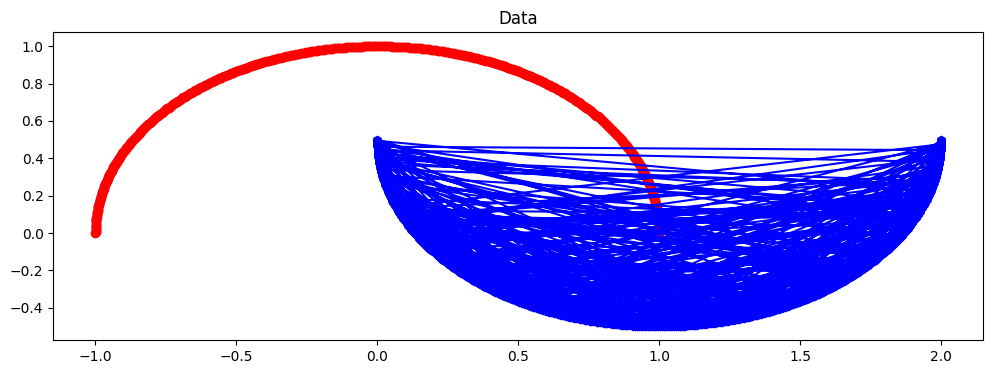

In [75]:
X, y = make_moons(n_samples = 1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

plot_data(X, y, title = 'Data')

In [6]:
train_dataset = Dataset(X_train, y_train)
test_dataset  = Dataset(X_test,  y_test)
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_dataloader  = DataLoader(test_dataset,  batch_size = 1, shuffle = False)

In [16]:
model = LogisticRegression()
optimizer = SGD(model.parameters())
criterion = nn.BCELoss()
writer = SummaryWriter()
saver = Saver(model_name = 'model', model_dir = 'models')
graph_logged = False

In [17]:
n_epochs = 250
save_interval = 10
initial_epoch, model = saver.start_or_resume_training(model)

model.train()
for epoch in range(initial_epoch, n_epochs + 1):
    print(f'Epoch {epoch}/{n_epochs}')

    total_loss = 0
    for i, (x, y_true) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        y_pred = model(x)
        if not graph_logged:
            writer.add_graph(model, x)
            graph_logged = True
        loss = criterion(y_pred, y_true)
        loss_value = loss.item()
        step = (epoch - 1) * len(train_dataloader) + i
        writer.add_scalar("Loss/batch_train_loss", loss_value, step)
        total_loss += loss_value
        loss.backward()
        optimizer.step()
    
    epoch_loss = total_loss / len(train_dataloader)
    writer.add_scalar("Loss/epoch_train_loss", epoch_loss, epoch)
    print('Training loss:', epoch_loss)

    if epoch % save_interval == 0:
        saver.save_model(model, epoch)

saver.save_model(model)



Resuming training from epoch 51...
Epoch 50/250


  0%|          | 0/250 [00:00<?, ?it/s]/home/jpvmello/Área de Trabalho/Jean/venvs/handson_torch/lib/python3.9/site-packages/torch/jit/_trace.py:165: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  if a.grad is not None:
100%|██████████| 250/250 [00:00<00:00, 254.31it/s]


Training loss: 0.26211267688320383
Epoch 51/250


100%|██████████| 250/250 [00:00<00:00, 415.79it/s]


Training loss: 0.2620040303877077
Epoch 52/250


100%|██████████| 250/250 [00:00<00:00, 460.48it/s]


Training loss: 0.26189575554686223
Epoch 53/250


100%|██████████| 250/250 [00:00<00:00, 509.55it/s]


Training loss: 0.2617882403468141
Epoch 54/250


100%|██████████| 250/250 [00:00<00:00, 504.10it/s]


Training loss: 0.2616812879888775
Epoch 55/250


100%|██████████| 250/250 [00:00<00:00, 499.96it/s]


Training loss: 0.2615747588091325
Epoch 56/250


100%|██████████| 250/250 [00:00<00:00, 512.53it/s]


Training loss: 0.2614690401464534
Epoch 57/250


100%|██████████| 250/250 [00:00<00:00, 512.66it/s]


Training loss: 0.26136408267538486
Epoch 58/250


100%|██████████| 250/250 [00:00<00:00, 483.41it/s]


Training loss: 0.2612594149262143
Epoch 59/250


100%|██████████| 250/250 [00:00<00:00, 406.74it/s]


Training loss: 0.26115577745952784
Epoch 60/250


100%|██████████| 250/250 [00:00<00:00, 414.95it/s]


Training loss: 0.2610526317772831
Epoch 61/250


100%|██████████| 250/250 [00:00<00:00, 445.21it/s]


Training loss: 0.260950072671291
Epoch 62/250


100%|██████████| 250/250 [00:00<00:00, 508.90it/s]


Training loss: 0.2608481078963724
Epoch 63/250


100%|██████████| 250/250 [00:00<00:00, 574.77it/s]


Training loss: 0.2607467997933846
Epoch 64/250


100%|██████████| 250/250 [00:00<00:00, 499.69it/s]


Training loss: 0.26064588789455945
Epoch 65/250


100%|██████████| 250/250 [00:00<00:00, 452.08it/s]


Training loss: 0.2605456368443891
Epoch 66/250


100%|██████████| 250/250 [00:00<00:00, 461.55it/s]


Training loss: 0.26044590900727355
Epoch 67/250


100%|██████████| 250/250 [00:00<00:00, 513.63it/s]


Training loss: 0.2603469357115602
Epoch 68/250


100%|██████████| 250/250 [00:00<00:00, 465.00it/s]


Training loss: 0.26024872682578604
Epoch 69/250


100%|██████████| 250/250 [00:00<00:00, 477.32it/s]


Training loss: 0.26015089599536717
Epoch 70/250


100%|██████████| 250/250 [00:00<00:00, 407.36it/s]


Training loss: 0.26005351034357027
Epoch 71/250


100%|██████████| 250/250 [00:00<00:00, 428.36it/s]


Training loss: 0.25995683079933
Epoch 72/250


100%|██████████| 250/250 [00:00<00:00, 452.52it/s]


Training loss: 0.25986075473067166
Epoch 73/250


100%|██████████| 250/250 [00:00<00:00, 443.53it/s]


Training loss: 0.25976527419560674
Epoch 74/250


100%|██████████| 250/250 [00:00<00:00, 477.54it/s]


Training loss: 0.2596701471191323
Epoch 75/250


100%|██████████| 250/250 [00:00<00:00, 458.93it/s]


Training loss: 0.2595754858758402
Epoch 76/250


100%|██████████| 250/250 [00:00<00:00, 447.83it/s]


Training loss: 0.25948172298382643
Epoch 77/250


100%|██████████| 250/250 [00:00<00:00, 434.66it/s]


Training loss: 0.25938825299102164
Epoch 78/250


100%|██████████| 250/250 [00:00<00:00, 506.12it/s]


Training loss: 0.2592954576429607
Epoch 79/250


100%|██████████| 250/250 [00:00<00:00, 510.96it/s]


Training loss: 0.2592030354093608
Epoch 80/250


100%|██████████| 250/250 [00:00<00:00, 503.81it/s]


Training loss: 0.25911116907005505
Epoch 81/250


100%|██████████| 250/250 [00:00<00:00, 438.03it/s]


Training loss: 0.25902016351969415
Epoch 82/250


100%|██████████| 250/250 [00:00<00:00, 498.53it/s]


Training loss: 0.2589295395368602
Epoch 83/250


100%|██████████| 250/250 [00:00<00:00, 493.30it/s]


Training loss: 0.2588390078248199
Epoch 84/250


100%|██████████| 250/250 [00:00<00:00, 478.71it/s]


Training loss: 0.25874959206679454
Epoch 85/250


100%|██████████| 250/250 [00:00<00:00, 405.55it/s]


Training loss: 0.258660081199782
Epoch 86/250


100%|██████████| 250/250 [00:00<00:00, 468.16it/s]


Training loss: 0.25857146859037516
Epoch 87/250


100%|██████████| 250/250 [00:00<00:00, 454.87it/s]


Training loss: 0.25848318144913424
Epoch 88/250


100%|██████████| 250/250 [00:00<00:00, 525.45it/s]


Training loss: 0.25839558224148235
Epoch 89/250


100%|██████████| 250/250 [00:00<00:00, 500.96it/s]


Training loss: 0.25830862710808666
Epoch 90/250


100%|██████████| 250/250 [00:00<00:00, 443.47it/s]


Training loss: 0.2582218770259416
Epoch 91/250


100%|██████████| 250/250 [00:00<00:00, 438.37it/s]


Training loss: 0.25813553495278074
Epoch 92/250


100%|██████████| 250/250 [00:00<00:00, 401.01it/s]


Training loss: 0.2580494353354949
Epoch 93/250


100%|██████████| 250/250 [00:00<00:00, 495.08it/s]


Training loss: 0.25796470219830253
Epoch 94/250


 84%|████████▍ | 211/250 [00:00<00:00, 489.77it/s]


KeyboardInterrupt: 

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:01<00:00, 1577.70it/s]


Test loss: 0.2478866439425027
Accuracy: 0.885


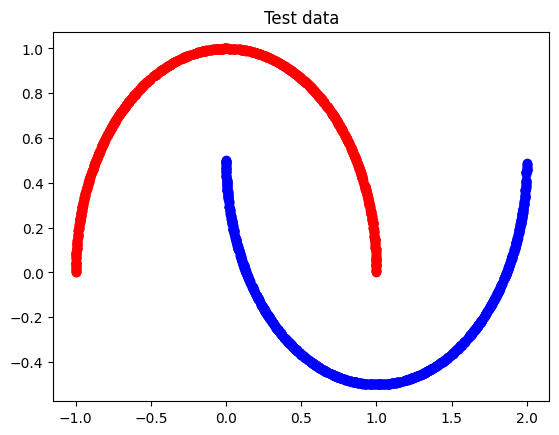

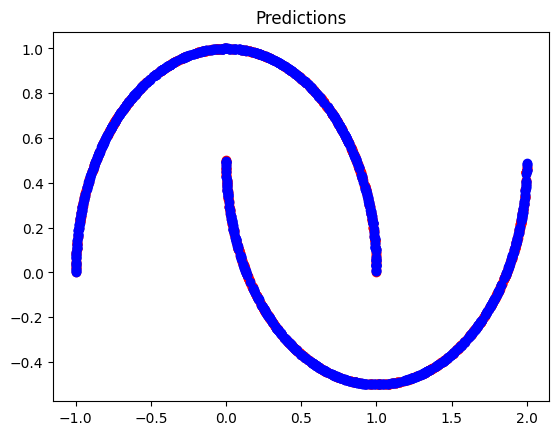

In [48]:
model.eval()

with torch.no_grad():
    total_loss = 0
    correct = 0
    y_pred = []
    for i, (x, y_true) in enumerate(tqdm(test_dataloader)):
        y_pred_i = model(x)
        loss = criterion(y_pred_i, y_true)
        total_loss += loss.item()
        y_pred.append(torch.round(y_pred_i))
        if y_true == y_pred[-1]:
            correct += 1
    
    test_loss = total_loss / len(test_dataloader)
    writer.add_scalar("Loss/test_loss-X", test_loss)
    print('Test loss:', test_loss)
    print('Accuracy:', correct / len(test_dataloader)) # TODO: substituir por acurácia balanceada

    plot_data(X_test, y_test, title = 'Test data')
    plot_data(X_test, torch.Tensor(y_pred), title = 'Predictions')

In [15]:
writer.close()

In [47]:
y_pred

[0.3319232406565788,
 0.9585083933718695,
 0.7235357864576,
 0.04113518508249119,
 0.9411859384962734,
 0.039826658279287004,
 0.9601904131539878,
 0.8735903406866177,
 0.8707577892603432,
 0.9751284388930228,
 0.03418225389815508,
 0.9659124369697792,
 0.029936448306354047,
 0.11538863283907862,
 0.5543407584413365,
 0.021633854331998194,
 0.5802749963648844,
 0.1434575503628078,
 0.41110001146679026,
 0.5118015935860502,
 0.72958783908037,
 0.052425425570624275,
 0.02200015442421778,
 0.02200586282430003,
 0.9686551052345356,
 0.19771448040428,
 0.18670468919872274,
 0.7608264571138941,
 0.20537869721533492,
 0.9714143113798024,
 0.27688759680400155,
 0.5192182025856247,
 0.3283890885155714,
 0.962672964190485,
 0.8678067188710484,
 0.8337834079809724,
 0.904667364586048,
 0.262517948525341,
 0.7049065666006092,
 0.7022763190113138,
 0.9757802541734754,
 0.976109468718907,
 0.08173480954694244,
 0.031228156566555112,
 0.9734411100930549,
 0.9610461444052755,
 0.9114483556960822,
 0.0